In [2]:
import os
import sys
import argparse
from collections import OrderedDict
from collections import OrderedDict as OD
import csv

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import hist
import mplhep as hep

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval # hyperparameter optimization
import pickle


from CommonTools import (
    convert_Et_to_logEt, 
    convert_logEt_to_Et, 
    convert_GenEt_to_GenEtByL1Et, 
    convert_GenEtByL1Et_to_GenEt, 
    convert_GenEt_to_logGenEtByL1Et, 
    convert_logGenEtByL1Et_to_GenEt,
    convert_CaloToolMPEta_to_IEta,
    GaussianFunction,
    calculate_errorOfRatio
)


parser = argparse.ArgumentParser()
parser.add_argument('--MLTarget',           type=str,   dest='MLTarget',  default='logGenEt', choices=['GenEt', 'logGenEt', 'GenEtByL1Et', 'logGenEtByL1Et'])
parser.add_argument('--PUForSFComputation', type=int,   dest='PUForSFComputation', help="PU at which SFs to compute", default='33')
parser.add_argument('--fracOfDataToUse',    type=float, dest='fracOfDataToUse', help="fraction of data to use", default='1.0')
parser.add_argument('--version',            type=str,   dest='version',   default='versionTmp')
parser.add_argument('--ipFile',             type=str,   dest='ipFile',    default='../../../JEC/newGT/output.csv')
parseGroup1 = parser.add_mutually_exclusive_group(required=True)
parseGroup1.add_argument('--ChunkyDonut',    action='store_true')
parseGroup1.add_argument('--PhiRing',        action='store_true')
parseGroup2 = parser.add_mutually_exclusive_group(required=True)
parseGroup2.add_argument('--l1MatchOffline', action='store_true')
parseGroup2.add_argument('--l1MatchGen',     action='store_true')

runLocally = True # False

args = None
if not runLocally:
    matplotlib.use('Agg') # use for condor jobs to disable display of plots
    args = parser.parse_args()
else:
    #args = parser.parse_args("--ChunkyDonut --l1MatchGen --MLTarget logGenEt --fracOfDataToUse 0.01".split()) # to run in jupyter-notebook     
    #args = parser.parse_args("--ChunkyDonut --l1MatchGen --MLTarget GenEt --fracOfDataToUse 0.01".split()) # to run in jupyter-notebook 
    args = parser.parse_args("--PhiRing     --l1MatchOffline --MLTarget GenEt       --fracOfDataToUse 1.00".split()) # to run in jupyter-notebook     
    #from IPython.display import display, HTML
    #display(HTML("<style>.container { width:100% !important; }</style>"))

l1Jet_ChunkyDonut  = args.ChunkyDonut
l1Jet_PhiRing      = args.PhiRing
l1MatchOffline     = args.l1MatchOffline
l1MatchGen         = args.l1MatchGen
fracOfDataToUse    = args.fracOfDataToUse
MLTarget           = args.MLTarget
PUForSFComputation = args.PUForSFComputation
version0           = args.version
sIpFileName        = args.ipFile


printLevel = PrintLevel = 5
iEtaBins = [i for i in range(1, 42) if i!=29]
sL1JetEt_PUS_ChunkyDonut = 'L1JetEt_PUS_ChunkyDonut'
sL1JetEt_PUS_PhiRing     = 'L1JetEt_PUS_PhiRing'
sOfflineJetEt            = 'PFJetEtCorr'
sGenJetEt                = 'GenJetEt'
sL1JetTowerIEtaAbs       = 'L1JetTowerIEtaAbs'
L1JetPtThrsh             = 10.0 # GeV
L1JetPtMax               = 255.0 # GeV
RefJetPtLowThrsh         = 10.0 # GeV
RefJetPtHighThrsh        = 999999 #400.0 # GeV
snVtx                    = 'nVertexReco'
UsePUCapping             = False # False
MaxEt7PUTT               = 999999 #200 # GeV
iEtaBinsForPUCapping     = [i for i in range(1, 20) if i!=29] # https://indico.cern.ch/event/1387215/contributions/5831385/attachments/2808676/4902041/jets.pdf#page=11

NCompPtBins = 16 # 16 # No. of compressed pT bins
calibSF_L1JetPtRange = [15., 255., 1.] # [<lowest pT>,  <hightest pT>,  <pT bin width>] # pT range for SFs to read from Syed's SF.csv file
LUT_PtRange = [0., 255., 1.] # pT range for SFs for LUT
SF_forZeroPt = 1.0



sL1JetEt  = sL1JetEt_PUS_ChunkyDonut if l1Jet_ChunkyDonut else sL1JetEt_PUS_PhiRing
sRefJetEt = sOfflineJetEt if l1MatchOffline else sGenJetEt 

##sIpFileName     = "../data/L1T_Jet_MLInputs_2024_Muon_Run2023D-ZMu-PromptReco_JEC2024v0_13_3_0_L1SFLLR20240311wZSHF4p5GeV.csv"
version         = "v%s_%s_MLTarget_%s_%s" % (sL1JetEt, sRefJetEt, MLTarget, version0) 
sOpFileName_SFs = "../data/L1T_Jet_SFs_tmp_%s.csv" % (version)
sOutDir         = "./plots_%s" % (version)


#sOpFileName_SFs = sOpFileName_SFs.replace('.csv', '_%s.csv' % (sL1JetEt))
#sOutDir = '%s_%s' % (sOutDir, sL1JetEt)

plotPerformancePlots = True

PT_CAT = OD()
PT_CAT['Ptlt25']   = [ 0,  15,   25]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt25To35'] = [25,  30,   35]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt35To60'] = [35,  55,   60]  ## Low pT, turn-on threshold, high pT
PT_CAT['Pt60To90'] = [60,  75,   90]  ## Low pT, turn-on threshold, high pT   #[60,  90,   90]
PT_CAT['Ptgt90']   = [90, 120, 9999]  ## Low pT, turn-on threshold, high pT

ETA_CAT = OD()
ETA_CAT['HBEF'] = [0.000, 5.210]  ## Whole detector, 1 - 41
ETA_CAT['HB']   = [0.000, 1.392]  ## Trigger towers  1 - 16
ETA_CAT['HE1']  = [1.392, 1.740]  ## Trigger towers 17 - 20
ETA_CAT['HE2a'] = [1.740, 2.322]  ## Trigger towers 21 - 25
ETA_CAT['HE2b'] = [2.322, 3.000]  ## Trigger towers 26 - 28
ETA_CAT['HF']   = [3.000, 5.210]  ## Trigger towers 30 - 41

IETA_CAT = OD()
IETA_CAT['HBEF'] = [ 1, 41]  ## Whole detector, 1 - 41
IETA_CAT['HB']   = [ 1, 16]  ## Trigger towers  1 - 16
IETA_CAT['HE1']  = [17, 20]  ## Trigger towers 17 - 20
IETA_CAT['HE2a'] = [21, 25]  ## Trigger towers 21 - 25
IETA_CAT['HE2b'] = [26, 28]  ## Trigger towers 26 - 28
IETA_CAT['HF']   = [30, 41]  ## Trigger towers 30 - 41

CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018 = OrderedDict([
    ( 0, [*range(1, 5+1)]),  # 0
    ( 1, [*range(6, 9+1)]),  # 1
    ( 2, [*range(10,13+1)]), # 2
    ( 3, [*range(14,15+1)]), # 3
    ( 4, [*range(16,17+1)]), # 4
    ( 5, [*range(18,19+1)]), # 5
    ( 6, [*range(20,21+1)]), # 6
    ( 7, [22]), # 7
    ( 8, [23]), # 8
    ( 9, [24]), # 9
    (10, [25]), # 10
    (11, [26]), # 11
    (12, [*range(27,28+1)]), # 12
    (13, [*range(29,31+1)]), # 13
    (14, [*range(32,35+1)]), # 14
    (15, [*range(36,40+1)]), # 15
])
CaloToolMPEtaBinsMerge_forEtaCompressedLUT = CaloToolMPEtaBinsMerge_forEtaCompressedLUT_2018

useAbsEtaBins = True
# ETA_Bins = [26,27,28]
ETA_Bins = []
for iEta in range(-41,42):
    if iEta in [-29, 0, 29]:        continue;
    if useAbsEtaBins and iEta < 0:  continue;
    ETA_Bins.append(str(iEta))


sOutDirBeforeJEC    = "%s/beforeJEC" % (sOutDir)
sOutDirAfterJEC     = "%s/afterJEC_atPU%d" % (sOutDir,PUForSFComputation)
sOutDirBeforeJEC_1D = '%s/1D' % (sOutDirBeforeJEC)
sOutDirAfterJEC_1D  = '%s/1D' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir):             os.makedirs( sOutDir, exist_ok = True )
if not os.path.exists(sOutDirBeforeJEC):    os.makedirs( sOutDirBeforeJEC, exist_ok = True )
if not os.path.exists(sOutDirAfterJEC):     os.makedirs( sOutDirAfterJEC, exist_ok = True )    
if not os.path.exists(sOutDirBeforeJEC_1D): os.makedirs( sOutDirBeforeJEC_1D, exist_ok = True )    
if not os.path.exists(sOutDirAfterJEC_1D):  os.makedirs( sOutDirAfterJEC_1D, exist_ok = True )
if not os.path.exists("../data"):           os.makedirs("../data", exist_ok = True)
    
print("Input file: %s" % (sIpFileName))
print(f"{fracOfDataToUse = }")
print(f"{PUForSFComputation = }")
print(f"{version = }")
print("iEtaBins ({}): {}".format(len(iEtaBins), iEtaBins))
print("sRefJetEt: {}, \t sL1Jet: {}, \t L1JetPtThrsh: {}".format(sRefJetEt, sL1JetEt, L1JetPtThrsh))
print("l1Jet_ChunkyDonut {}, l1Jet_PhiRing {}, l1MatchOffline {}, l1MatchGen {}".format(
    l1Jet_ChunkyDonut, l1Jet_PhiRing, l1MatchOffline, l1MatchGen)); sys.stdout.flush();    

Input file: ../../../JEC/newGT/output.csv
fracOfDataToUse = 1.0
PUForSFComputation = 33
version = 'vL1JetEt_PUS_PhiRing_PFJetEtCorr_MLTarget_GenEt_versionTmp'
iEtaBins (40): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
sRefJetEt: PFJetEtCorr, 	 sL1Jet: L1JetEt_PUS_PhiRing, 	 L1JetPtThrsh: 10.0
l1Jet_ChunkyDonut False, l1Jet_PhiRing True, l1MatchOffline True, l1MatchGen False


In [3]:

data_all = pd.read_csv(sIpFileName)

In [4]:
print("Original sample: data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

Original sample: data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'nTT_Emulated', 'PFJetEtCorr', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt', 'L1JetDefault_PUEt_PhiRing',
       'L1Jet9x9_RawEt', 'L1Jet9x9_EtSum7PUTowers',
       'L1Jet9x9_PUEt_ChunkyDonut'],
      dtype='object'), 
data_all.shape: (6856335, 14)


In [5]:
data_all[sL1JetEt_PUS_ChunkyDonut] = data_all['L1Jet9x9_RawEt'] - data_all['L1Jet9x9_PUEt_ChunkyDonut']

# data_all[sL1JetEt_PUS_PhiRing]     = data_all['L1Jet9x9_RawEt'] - (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )
# data_all[sL1JetEt_PUS_PhiRing]     = data_all['L1JetDefault_RawEt'] - (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )
# data_all[sL1JetEt_PUS_PhiRing] = data_all['L1JetDefault_RawEt'] - data_all['L1JetDefault_PUEt_PhiRing']
# data_all['PUEt_PhiRing'] = (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )
if UsePUCapping:
    # PU capping: https://indico.cern.ch/event/1387215/contributions/5831385/attachments/2808676/4902041/jets.pdf#page=11
    # In |iEta| < 20, (Maximum Phi-Ring Et) = RawEt + 200 GeV  i.e. (Maximu EtSum7PUTowers) = 200 
    data_all['L1JetDefault_PUEt_PhiRing'].where( # Where cond is True, keep the original value. Where False, replace with corresponding value from other.
        ((~data_all['L1JetTowerIEtaAbs'].isin(iEtaBinsForPUCapping)) | 
        ( data_all['L1Jet9x9_EtSum7PUTowers'] < MaxEt7PUTT) ),
        (MaxEt7PUTT / 7.0),
        inplace = True 
    )
data_all[sL1JetEt_PUS_PhiRing] = data_all['L1JetDefault_RawEt'] - data_all['L1JetDefault_PUEt_PhiRing']

In [6]:
# Check PU vs iEta
puMean_list = []
puMax_list  = []
puCappedMean_list = []
puCappedMax_list  = []
for iEta in iEtaBins:
    puMean = data_all[data_all[sL1JetTowerIEtaAbs] == iEta]['L1JetDefault_PUEt_PhiRing'].mean()
    puMax  = data_all[data_all[sL1JetTowerIEtaAbs] == iEta]['L1JetDefault_PUEt_PhiRing'].max()
    puCappedMean = data_all[data_all[sL1JetTowerIEtaAbs] == iEta]['L1JetDefault_PUEt_PhiRing'].mean()
    puCappedMax  = data_all[data_all[sL1JetTowerIEtaAbs] == iEta]['L1JetDefault_PUEt_PhiRing'].max()
    # puMean = (data_all[data_all[sL1JetTowerIEtaAbs] == iEta]['L1Jet9x9_EtSum7PUTowers'] / 7.0).mean()
    # puMax  = (data_all[data_all[sL1JetTowerIEtaAbs] == iEta]['L1Jet9x9_EtSum7PUTowers'] / 7.0).max()
    # puCappedMean = data_all[data_all[sL1JetTowerIEtaAbs] == iEta]['PUEt_PhiRing'].mean()
    # puCappedMax  = data_all[data_all[sL1JetTowerIEtaAbs] == iEta]['PUEt_PhiRing'].max()
    puMean_list.append( puMean )
    puMax_list.append(  puMax  )
    puCappedMean_list.append( puCappedMean )
    puCappedMax_list.append(  puCappedMax  )    

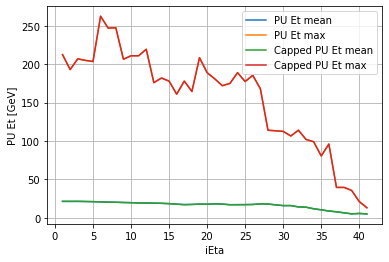

In [7]:
fig, axs = plt.subplots()
axs.plot(iEtaBins, puMean_list, label='PU Et mean')
axs.plot(iEtaBins, puMax_list, label='PU Et max')
axs.plot(iEtaBins, puCappedMean_list, label='Capped PU Et mean')
axs.plot(iEtaBins, puCappedMax_list, label='Capped PU Et max')
axs.set_xlabel('iEta'); axs.set_ylabel('PU Et [GeV]')
axs.legend(loc='best')
axs.axis('tight')
axs.grid()
fig.show()

In [8]:
data_all.loc[data_all['L1JetDefault_PUEt_PhiRing'].argmax()]

runNumber                       392296
lumiSectionNumber                  130
eventNumber                  217360139
nVertexReco                         35
nTT_Emulated                       211
PFJetEtCorr                      804.0
L1JetType                          emu
L1JetDefault_Et                  605.0
L1JetTowerIEtaAbs                    6
L1JetDefault_RawEt               677.5
L1JetDefault_PUEt_PhiRing        262.5
L1Jet9x9_RawEt                   677.5
L1Jet9x9_EtSum7PUTowers         1423.5
L1Jet9x9_PUEt_ChunkyDonut          1.0
L1JetEt_PUS_ChunkyDonut          676.5
L1JetEt_PUS_PhiRing              415.0
Name: 709057, dtype: object

In [9]:
#data_all.loc[data_all['PUEt_PhiRing'].argmax()]['L1JetTowerIEtaAbs'].isin(iEtaBinsForPUCapping)
data_all[~data_all['L1JetTowerIEtaAbs'].isin(iEtaBinsForPUCapping)].describe()

,runNumber,lumiSectionNumber,eventNumber,nVertexReco,nTT_Emulated,PFJetEtCorr,L1JetDefault_Et,L1JetTowerIEtaAbs,L1JetDefault_RawEt,L1JetDefault_PUEt_PhiRing,L1Jet9x9_RawEt,L1Jet9x9_EtSum7PUTowers,L1Jet9x9_PUEt_ChunkyDonut,L1JetEt_PUS_ChunkyDonut,L1JetEt_PUS_PhiRing
count,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06,2.490177e+06
mean,3.926435e+05,5.217406e+02,1.073029e+09,3.887060e+01,1.379911e+02,1.242902e+02,1.207901e+02,2.735891e+01,9.051108e+01,1.611964e+01,9.051108e+01,4.012733e+01,1.851485e+00,8.865960e+01,7.439144e+01
std,2.792462e+02,3.996820e+02,8.958083e+08,8.995745e+00,5.753696e+01,9.267180e+01,9.093170e+01,4.410538e+00,7.455724e+01,1.242932e+01,7.455724e+01,5.833398e+01,3.046084e+00,7.438288e+01,6.486784e+01
min,3.922950e+05,1.000000e+00,1.800000e+02,0.000000e+00,3.000000e+00,1.500000e+01,5.000000e-01,2.000000e+01,4.000000e+00,5.000000e-01,4.000000e+00,0.000000e+00,0.000000e+00,-6.600000e+01,5.000000e-01
25%,3.924420e+05,2.020000e+02,3.518314e+08,3.300000e+01,9.800000e+01,5.087500e+01,4.750000e+01,2.400000e+01,2.900000e+01,7.000000e+00,2.900000e+01,1.150000e+01,0.000000e+00,2.750000e+01,2.100000e+01
50%,3.925380e+05,4.340000e+02,8.576328e+08,3.900000e+01,1.290000e+02,1.009375e+02,1.000000e+02,2.800000e+01,7.050000e+01,1.350000e+01,7.050000e+01,2.250000e+01,1.000000e+00,6.800000e+01,5.650000e+01
75%,3.929910e+05,7.280000e+02,1.483259e+09,4.500000e+01,1.680000e+02,1.688750e+02,1.670000e+02,3.000000e+01,1.330000e+02,2.150000e+01,1.330000e+02,4.400000e+01,2.500000e+00,1.315000e+02,1.125000e+02
max,3.930870e+05,1.946000e+03,4.381039e+09,1.080000e+02,7.310000e+02,9.000000e+02,9.990000e+02,4.100000e+01,7.655000e+02,1.890000e+02,7.655000e+02,1.266500e+03,1.460000e+02,7.605000e+02,6.665000e+02


In [10]:
data_all[(data_all['L1JetTowerIEtaAbs'].isin(iEtaBinsForPUCapping) & ( data_all['L1Jet9x9_EtSum7PUTowers'] > MaxEt7PUTT) )]

,runNumber,lumiSectionNumber,eventNumber,nVertexReco,nTT_Emulated,PFJetEtCorr,L1JetType,L1JetDefault_Et,L1JetTowerIEtaAbs,L1JetDefault_RawEt,L1JetDefault_PUEt_PhiRing,L1Jet9x9_RawEt,L1Jet9x9_EtSum7PUTowers,L1Jet9x9_PUEt_ChunkyDonut,L1JetEt_PUS_ChunkyDonut,L1JetEt_PUS_PhiRing


In [ ]:
#%%script false --no-raise-error
# L1JetEt per iEta bin before data cleaning -------------

sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetEt' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    
plotPerformancePlots = True
if plotPerformancePlots:    
    for iEta in ETA_Bins:
        print("iEta %d"%(int(iEta)))

        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')      

        iEtaBin = int(iEta)
        data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]), 
            bins=100, range=(0, 300),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
        )
        axs.set_xlabel('L1JetEt')
        axs.set_ylabel('Normalized entries')
        axs.set_title('iEta %d' % (iEtaBin))
        axs.legend()

        fig.savefig('%s/L1JetEt_ieta_%d.pdf' % (sOutDir1D_toUse, iEtaBin))
        plt.close(fig) 

iEta 1
iEta 2
iEta 3
iEta 4
iEta 5
iEta 6
iEta 7
iEta 8
iEta 9
iEta 10
iEta 11
iEta 12
iEta 13
iEta 14
iEta 15
iEta 16
iEta 17
iEta 18
iEta 19
iEta 20
iEta 21
iEta 22
iEta 23
iEta 24
iEta 25
iEta 26
iEta 27
iEta 28
iEta 30
iEta 31
iEta 32
iEta 33
iEta 34
iEta 35
iEta 36
iEta 37
iEta 38
iEta 39
iEta 40
iEta 41


In [12]:
## data cleaning--------

# Drop entries with L1JetEt < L1JetPtThrsh
data_all_L1EtBelowThrsh = data_all[(
    (data_all[sL1JetEt]  < L1JetPtThrsh) | 
    (data_all[sRefJetEt] < RefJetPtLowThrsh) |
    (data_all[sRefJetEt] > RefJetPtHighThrsh)
)]
if printLevel >= 8:
    print("data_all[ data_all['{}'] < {} ]: \n{}".format(sL1JetEt, L1JetPtThrsh, data_all_L1EtBelowThrsh))
data_all.drop(index=data_all_L1EtBelowThrsh.index, inplace=True)

print("\nDoes any of the columns have NaN entries: \ndata_all.isna().sum(): \n{}".format(data_all.isna().sum()))
if printLevel >= 5:
    print("\nAfter cleaning, data_all.describe(): \n{}".format(data_all.describe()))


Does any of the columns have NaN entries: 
data_all.isna().sum(): 
runNumber                    0
lumiSectionNumber            0
eventNumber                  0
nVertexReco                  0
nTT_Emulated                 0
PFJetEtCorr                  0
L1JetType                    0
L1JetDefault_Et              0
L1JetTowerIEtaAbs            0
L1JetDefault_RawEt           0
L1JetDefault_PUEt_PhiRing    0
L1Jet9x9_RawEt               0
L1Jet9x9_EtSum7PUTowers      0
L1Jet9x9_PUEt_ChunkyDonut    0
L1JetEt_PUS_ChunkyDonut      0
L1JetEt_PUS_PhiRing          0
dtype: int64

After cleaning, data_all.describe(): 
          runNumber  lumiSectionNumber   eventNumber   nVertexReco  \
count  6.118142e+06       6.118142e+06  6.118142e+06  6.118142e+06   
mean   3.926478e+05       5.308287e+02  1.093641e+09  3.806011e+01   
std    2.793200e+02       4.054074e+02  9.068988e+08  8.730672e+00   
min    3.922950e+05       1.000000e+00  1.800000e+02  0.000000e+00   
25%    3.924420e+05       2.050000

In [13]:
print("After data cleaning: data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

After data cleaning: data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'nTT_Emulated', 'PFJetEtCorr', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt', 'L1JetDefault_PUEt_PhiRing',
       'L1Jet9x9_RawEt', 'L1Jet9x9_EtSum7PUTowers',
       'L1Jet9x9_PUEt_ChunkyDonut', 'L1JetEt_PUS_ChunkyDonut',
       'L1JetEt_PUS_PhiRing'],
      dtype='object'), 
data_all.shape: (6118142, 16)


In [14]:
data_all = data_all.sample(frac=fracOfDataToUse, random_state=1)

In [15]:
print("Sample to use: data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

Sample to use: data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'nTT_Emulated', 'PFJetEtCorr', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt', 'L1JetDefault_PUEt_PhiRing',
       'L1Jet9x9_RawEt', 'L1Jet9x9_EtSum7PUTowers',
       'L1Jet9x9_PUEt_ChunkyDonut', 'L1JetEt_PUS_ChunkyDonut',
       'L1JetEt_PUS_PhiRing'],
      dtype='object'), 
data_all.shape: (6118142, 16)


In [ ]:
#%%script false --no-raise-error
# L1JetEt per iEta bin after data cleaning -------------

sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetEt' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    

if plotPerformancePlots:    
    for iEta in ETA_Bins:
        print("iEta %d"%(int(iEta)))

        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')      

        iEtaBin = int(iEta)
        data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]), 
            bins=100, range=(0, 300),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
        )
        axs.set_xlabel('L1JetEt')
        axs.set_ylabel('Normalized entries')
        axs.set_title('iEta %d' % (iEtaBin))
        axs.legend()

        fig.savefig('%s/L1JetEt_ieta_%d_afterDataCleaning.pdf' % (sOutDir1D_toUse, iEtaBin))
        plt.close(fig)

iEta 1
iEta 2
iEta 3
iEta 4
iEta 5
iEta 6
iEta 7
iEta 8
iEta 9
iEta 10
iEta 11
iEta 12
iEta 13
iEta 14
iEta 15
iEta 16
iEta 17
iEta 18
iEta 19
iEta 20
iEta 21
iEta 22
iEta 23
iEta 24
iEta 25
iEta 26
iEta 27
iEta 28
iEta 30
iEta 31
iEta 32
iEta 33
iEta 34
iEta 35
iEta 36
iEta 37
iEta 38
iEta 39
iEta 40
iEta 41


In [17]:
# Closer for Et_to_logEt
if printLevel >= 15:
    data_all['logRefJetEt_tmp'] = convert_Et_to_logEt( data_all[sRefJetEt] )
    data_all['RefJetEt_recal_tmp'] = convert_logEt_to_Et( data_all['logRefJetEt_tmp'] )
    data_all['closure_logRefJetEt__tmp'] = data_all['RefJetEt_recal_tmp'] - data_all[sRefJetEt]

    print(f"{data_all[[sRefJetEt, 'logRefJetEt_tmp', 'RefJetEt_recal_tmp', 'closure_logRefJetEt__tmp']] = }")
    print(f"{ np.max(abs(data_all['closure_logRefJetEt__tmp'])) = }")

In [18]:
# Closer for GenEt_to_GenEtByL1Et
if printLevel >= 15:
    data_all['GenEtByL1Et_tmp'] = convert_GenEt_to_GenEtByL1Et( data_all[sRefJetEt], data_all[sL1JetEt] )
    data_all['RefJetEt_recal2_tmp'] = convert_GenEtByL1Et_to_GenEt( data_all['GenEtByL1Et_tmp'], data_all[sL1JetEt] )
    data_all['closure_GenEtByL1Et_tmp'] = data_all['RefJetEt_recal2_tmp'] - data_all[sRefJetEt]

    print(f"{data_all[[sRefJetEt, sL1JetEt, 'GenEtByL1Et_tmp', 'RefJetEt_recal2_tmp', 'closure_GenEtByL1Et_tmp']] = }")
    print(f"{ np.max(abs(data_all['closure_GenEtByL1Et_tmp'])) = }")

In [19]:
# Closer for GenEt_to_logGenEtByL1Et
if printLevel >= 15:
    data_all['logGenEtByL1Et_tmp'] = convert_GenEt_to_logGenEtByL1Et( data_all[sRefJetEt], data_all[sL1JetEt] )
    data_all['RefJetEt_recal3_tmp'] = convert_logGenEtByL1Et_to_GenEt( data_all['logGenEtByL1Et_tmp'], data_all[sL1JetEt] )
    data_all['closure_logGenEtByL1Et_tmp'] = data_all['RefJetEt_recal3_tmp'] - data_all[sRefJetEt]

    print(f"{data_all[[sRefJetEt, sL1JetEt, 'logGenEtByL1Et_tmp', 'RefJetEt_recal3_tmp', 'closure_logGenEtByL1Et_tmp']] = }")
    print(f"{ np.max(abs(data_all['closure_logGenEtByL1Et_tmp'])) = }")

In [20]:
# set trainning and target variables

sL1JetEt_forML  = None
sRefJetEt_forML = None

if   MLTarget == 'GenEt':
    sL1JetEt_forML  = sL1JetEt
    sRefJetEt_forML = sRefJetEt    
    
elif MLTarget == 'logGenEt':    
    sL1JetEt_forML  = 'log%s' % (sL1JetEt)
    sRefJetEt_forML = 'log%s' % (sRefJetEt)
    
    data_all[sL1JetEt_forML] = convert_Et_to_logEt( data_all[sL1JetEt] )
    data_all[sRefJetEt_forML] = convert_Et_to_logEt( data_all[sRefJetEt] )
    
elif MLTarget == 'GenEtByL1Et':    
    sL1JetEt_forML  = sL1JetEt
    sRefJetEt_forML = '%sBy%s' % (sRefJetEt, sL1JetEt)
        
    data_all[sRefJetEt_forML] = convert_GenEt_to_GenEtByL1Et( data_all[sRefJetEt], data_all[sL1JetEt] )   
    
elif MLTarget == 'logGenEtByL1Et':    
    sL1JetEt_forML  = 'log%s' % (sL1JetEt)
    sRefJetEt_forML = 'log%sBy%s' % (sRefJetEt, sL1JetEt)
    
    data_all[sL1JetEt_forML] = convert_Et_to_logEt( data_all[sL1JetEt] )
    data_all[sRefJetEt_forML] = convert_GenEt_to_logGenEtByL1Et( data_all[sRefJetEt],  data_all[sL1JetEt] )
    
    
train_vars = [sL1JetTowerIEtaAbs, sL1JetEt_forML, snVtx]
target_var = sRefJetEt_forML
print("\nsL1JetEt_forML: {}, sRefJetEt_forML: {}".format(sL1JetEt_forML, sRefJetEt_forML))
print("train_vars: {}, \ntarget_var: {}\n".format(train_vars, target_var))

if printLevel >= 1:
    print("data_all.describe(): \n{}".format(data_all.describe()))


sL1JetEt_forML: L1JetEt_PUS_PhiRing, sRefJetEt_forML: PFJetEtCorr
train_vars: ['L1JetTowerIEtaAbs', 'L1JetEt_PUS_PhiRing', 'nVertexReco'], 
target_var: PFJetEtCorr

data_all.describe(): 
          runNumber  lumiSectionNumber   eventNumber   nVertexReco  \
count  6.118142e+06       6.118142e+06  6.118142e+06  6.118142e+06   
mean   3.926478e+05       5.308287e+02  1.093641e+09  3.806011e+01   
std    2.793200e+02       4.054074e+02  9.068988e+08  8.730672e+00   
min    3.922950e+05       1.000000e+00  1.800000e+02  0.000000e+00   
25%    3.924420e+05       2.050000e+02  3.644653e+08  3.200000e+01   
50%    3.925380e+05       4.390000e+02  8.895332e+08  3.800000e+01   
75%    3.929910e+05       7.360000e+02  1.514603e+09  4.400000e+01   
max    3.930870e+05       1.946000e+03  4.381041e+09  1.110000e+02   

       nTT_Emulated   PFJetEtCorr  L1JetDefault_Et  L1JetTowerIEtaAbs  \
count  6.118142e+06  6.118142e+06     6.118142e+06       6.118142e+06   
mean   1.379665e+02  1.656008e+02  

In [ ]:
## L1Jet response per iEta before JEC

sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetResponse_perEtaBin' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    

if plotPerformancePlots:    
#print("".format())
    for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
        #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  

        for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
            iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
            data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
            axs.hist(
                (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
                bins=100, range=(0, 2.6),
                label='iEta %d' % (iEtaBin),
                histtype='step',#, linewidth=2
                density=True
            )
        axs.set_xlabel('L1JetEt / PUPPIJetEt')
        axs.set_ylabel('Normalized entries')
        axs.set_title('%s' % (sL1JetEt))
        axs.legend()

        fig.savefig('%s/L1JetResponse_beforeJEC_%s_ieta_%d_to_%d.pdf' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
        plt.close(fig)    


In [ ]:
## L1Jet response per iEta bin range before JEC

sOutDir_toUse   = sOutDirBeforeJEC
sOutDir1D_toUse = '%s/L1JetResponse_perEtaBinRange' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    

if plotPerformancePlots:
    for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
        #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
        iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
        iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])

        for pt_cat, pt_range in PT_CAT.items(): 
            data_all_iEtaBin = data_all[
                (data_all[sL1JetTowerIEtaAbs] >= iEtaBin_first) &  
                (data_all[sL1JetTowerIEtaAbs] <= iEtaBin_last) & 
                (data_all[sRefJetEt] >= pt_range[0]) &
                (data_all[sRefJetEt] <  pt_range[2])
            ]
            axs.hist(
                (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
                bins=100, range=(0, 2.6),
                label='%d <= PUPPIJetEt < %d' % (pt_range[0], pt_range[2]),
                histtype='step',#, linewidth=2
                density=True
            )
        axs.set_xlabel('L1JetEt / PUPPIJetEt')
        axs.set_ylabel('Normalized entries')
        axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
        axs.legend()

        fig.savefig('%s/L1JetResponse_beforeJEC_%s_ieta_%d_to_%d_inPtCat_%s.pdf' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1]), pt_cat))
        plt.close(fig)    


In [ ]:
# L1JetResponse vs Eta before JEC

sOutDir_toUse   = '%s/L1JetResponse_vs_Eta_perPU_perPtEtaCat' % (sOutDirBeforeJEC)
sOutDir1D_toUse = '%s/L1JetResponse_vs_Eta_perPU_perPtEtaCat/1D' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    


Pt_Cat_forResolutionPlots = OD()
#Pt_Cat_forResolutionPlots['Pt25to35'] = [25, 35]
Pt_Cat_forResolutionPlots['PtAll'] = [0, L1JetPtMax]

PU_Cat_forResolutionPlots = OD()
PU_Cat_forResolutionPlots['PUAll'] = [0, 99]

sL1JetEt_forResolutionPlots = sL1JetEt
sL1JetResponse = 'L1JetEt/%s' % (sRefJetEt)

if plotPerformancePlots:
    for PU_category, PURange in PU_Cat_forResolutionPlots.items():
        PURangeMin = PURange[0]
        PURangeMax = PURange[1]

        for Pt_category, PtRange in Pt_Cat_forResolutionPlots.items():
            PtRangeMin = PtRange[0]
            PtRangeMax = PtRange[1]

            JES = OD()
            JER = OD()
            for iEtaBin in iEtaBins:
                data_toUse_ = data_all[
                    (data_all[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                    (data_all[sRefJetEt]               >= PtRangeMin) &
                    (data_all[sRefJetEt]               <  PtRangeMax) & 
                    (data_all[snVtx]                   >= PURangeMin) &
                    (data_all[snVtx]                   <  PURangeMax)
                ]#.copy()
                data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
                print(f"PU: {PURange}, Pt: {PtRange}, iEta: {iEtaBin}")

                h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
                h.fill(data_toUse_[sL1JetResponse])

                x_    = h.axes[0].centers
                y_    = h.values()
                yErr_ = np.sqrt(h.variances())

                # index of bins with y>0
                idx_NonZeroY = np.nonzero(y_)

                # Give initial parameters for Gaussian function fit
                #pInitial = [y_.max(), 1, 0.3]
                pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]

                #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
                try:
                    popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
                except:
                    print(f"{PU_category = }, {Pt_category = }, {iEtaBin = }, {pInitial = }:  fit did not converge *** ")
                    continue
                poptErr    = np.sqrt(np.diag(pcov))
                print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")

                Mean_  = popt[1];    errMean_  = poptErr[1]
                Sigma_ = popt[2];    errSigma_ = poptErr[2]

                x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            

                fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
                axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
                axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
                axs.set_xlabel(sL1JetResponse)
                axs.set_ylabel('Entries')
                axs.set_title('%s %s iEta %s' % (PU_category, Pt_category, iEtaBin))
                axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
                axs.set_ylim(0, y_.max() * 1.4)
                axs.grid()

                errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
                JES[iEtaBin] = {'value': Mean_,          'error': errMean_}
                JER[iEtaBin] = {'value': Sigma_ / Mean_, 'error': errJER_}

                fig.savefig('%s/L1JetResponse_1D_%s_%s_ieta_%d.pdf' % (sOutDir1D_toUse, PU_category, Pt_category, iEtaBin))
                plt.close(fig)





            # plot JES vs iEta
            JES_iEtawise    = [ JES[iEtaBin]['value'] for iEtaBin in JES.keys()]
            errJES_iEtawise = [ JES[iEtaBin]['error'] for iEtaBin in JES.keys()]

            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            #axs.plot(list(JES.keys()), JES_iEtawise)
            axs.errorbar(list(JES.keys()), JES_iEtawise, yerr=errJES_iEtawise, fmt='o', markersize=1)
            axs.set_xlabel('iEta')
            axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
            axs.set_title('%s %s' % (PU_category, Pt_category))
            axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
            axs.margins(y=0.3)
            axs.grid()
            fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Mean.pdf' % (sOutDir_toUse, PU_category, Pt_category))
            plt.close(fig)


            # plot JER vs iEta
            JER_iEtawise    = [ JER[iEtaBin]['value'] for iEtaBin in JER.keys()]
            errJER_iEtawise = [ JER[iEtaBin]['error'] for iEtaBin in JER.keys()]

            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            #axs.plot(list(JES.keys()), JER_iEtawise)
            axs.errorbar(list(JER.keys()), JER_iEtawise, yerr=errJER_iEtawise, fmt='o', markersize=1)
            axs.set_xlabel('iEta')
            axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
            axs.set_title('%s %s' % (PU_category, Pt_category))
            axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
            axs.margins(y=0.3)
            axs.grid()
            fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Resolution.pdf' % (sOutDir_toUse, PU_category, Pt_category))     
            plt.close(fig)
        

In [ ]:
# L1Jet response vs RefJetPt before JEC

sOutDir_toUse   = '%s/L1JetResponse_vs_Pt_perPU_perPtEtaCat' % (sOutDirBeforeJEC)
sOutDir1D_toUse = '%s/L1JetResponse_vs_Pt_perPU_perPtEtaCat/1D' % (sOutDirBeforeJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    

    
RefJetPtBins_forResolutionPlots = [
    #*np.arange(  0.5,  20.5, 4),
    *np.arange( 20.5,  60.5, 2.5),
    *np.arange( 60.5, 120.5, 5),
    *np.arange(120.5, 255.5, 10),    
]
print(f"RefJetPtBins_forResolutionPlots: {RefJetPtBins_forResolutionPlots}")

if plotPerformancePlots:
    for PU_category, PURange in PU_Cat_forResolutionPlots.items():
        PURangeMin = PURange[0]
        PURangeMax = PURange[1]

        for iEtaBin in iEtaBins: # 1 to 41 iEtaBins

            JES = OD()
            JER = OD()
            for iPtBin in range(len(RefJetPtBins_forResolutionPlots) - 1):
                PtRangeMin = RefJetPtBins_forResolutionPlots[iPtBin]
                PtRangeMax = RefJetPtBins_forResolutionPlots[iPtBin + 1]
                PtMean = (PtRangeMin + PtRangeMax)/2

                data_toUse_ = data_all[
                    (data_all[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                    (data_all[sRefJetEt]               >= PtRangeMin) &
                    (data_all[sRefJetEt]               <  PtRangeMax) & 
                    (data_all[snVtx]                   >= PURangeMin) &
                    (data_all[snVtx]                   <  PURangeMax)
                ]#.copy()
                data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]

                h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
                h.fill(data_toUse_[sL1JetResponse])

                x_    = h.axes[0].centers
                y_    = h.values()
                yErr_ = np.sqrt(h.variances())

                fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
                axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
                #axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
                axs.set_xlabel(sL1JetResponse)
                axs.set_ylabel('Entries')
                axs.set_title('%s iEta %d pT [%.1f, %.1f]' % (PU_category, iEtaBin, PtRangeMin, PtRangeMax))


                # index of bins with y>0
                idx_NonZeroY = np.nonzero(y_)

                # Give initial parameters for Gaussian function fit
                #pInitial = [y_.max(), 1, 0.3]
                pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]
                if printLevel >= 5:
                    print(f"{PU_category = }, {iEtaBin = }, {PtRangeMin = }, {PtRangeMax = }, {pInitial = }")

                #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
                try:
                    popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
                except:
                    print(f"{PU_category = }, {iEtaBin = }, {PtRangeMin = }, {PtRangeMax = }, {pInitial = }:  fit did not converge *** ")
                    continue

                poptErr    = np.sqrt(np.diag(pcov))
                print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")

                Mean_  = popt[1];    errMean_  = poptErr[1]
                Sigma_ = popt[2];    errSigma_ = poptErr[2]

                x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            

                #fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
                #axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
                axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
                #axs.set_xlabel(sL1JetResponse)
                #axs.set_ylabel('Entries')
                #axs.set_title('%s iEta %d pT [%.1f, %.1f]' % (PU_category, iEtaBin, PtRangeMin, PtRangeMax))
                axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
                axs.set_ylim(0, y_.max() * 1.4)
                axs.grid()

                errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
                JES[PtMean] = {'value': Mean_,          'error': errMean_}
                JER[PtMean] = {'value': Sigma_ / Mean_, 'error': errJER_}

                fig.savefig('%s/L1JetResponse_1D_%s_ieta_%d_Pt_%.1f.pdf' % (sOutDir1D_toUse, PU_category, iEtaBin, PtMean))
                plt.close(fig)


            # plot JES vs Pt
            JES_Ptwise    = [ JES[Pt]['value'] for Pt in JES.keys()]
            errJES_Ptwise = [ JES[Pt]['error'] for Pt in JES.keys()]

            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(list(JES.keys()), JES_Ptwise, yerr=errJES_Ptwise, fmt='o', markersize=1)
            axs.set_xlabel('%s [GeV]' % (sRefJetEt))
            axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
            axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
            axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
            axs.margins(y=0.3)
            axs.grid()
            fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Mean.pdf' % (sOutDir_toUse, PU_category, iEtaBin))  
            plt.close(fig)

            # plot JER vs iEta
            JER_Ptwise    = [ JER[Pt]['value'] for Pt in JER.keys()]
            errJER_Ptwise = [ JER[Pt]['error'] for Pt in JER.keys()]

            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(list(JER.keys()), JER_Ptwise, yerr=errJER_Ptwise, fmt='o', markersize=1)
            axs.set_xlabel('%s [GeV]' % (sRefJetEt))
            axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
            axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
            axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
            axs.margins(y=0.3)
            fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Resolution.pdf' % (sOutDir_toUse, PU_category, iEtaBin))
            plt.close(fig)       

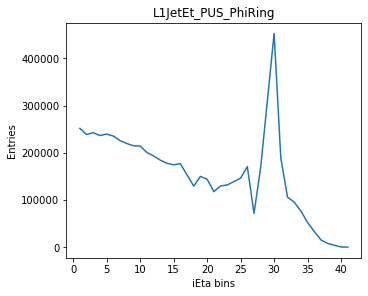

In [ ]:
# nEntries per iEta bin 

sOutDir_toUse   = sOutDirBeforeJEC

nEntriesPerIEtaBin = [len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins]   
nEntriesPerIEtaBin_1 = { iEtaBin: len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins}   
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
axs.plot(iEtaBins, nEntriesPerIEtaBin)
axs.set_xlabel('iEta bins')
axs.set_ylabel('Entries')
axs.set_title('%s' % (sL1JetEt))
#axs.legend()
fig.savefig('%s/%s_nEntriesPerIEtaBin.pdf' % (sOutDir, sL1JetEt))
if printLevel >= 11:
    print("nEntriesPerIEtaBin: {}".format(nEntriesPerIEtaBin))
    print("nEntriesPerIEtaBin_1: {}".format(nEntriesPerIEtaBin_1))
    


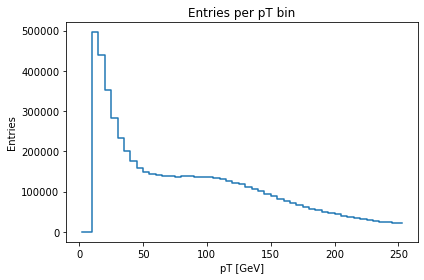

In [ ]:
# nEntries per pT bin 

pt_bin_edges = np.arange(0, L1JetPtMax+5, 5)  # 5 GeV bins

# Bin and count
data_all['pt_bin'] = pd.cut(data_all[sL1JetEt], bins=pt_bin_edges, right=False)
nEntriesPerPtBin = data_all['pt_bin'].value_counts().sort_index()

# Plot
fig, axs = plt.subplots(figsize=(6,4))
bin_centers = pt_bin_edges[:-1] + np.diff(pt_bin_edges)/2
axs.plot(bin_centers, nEntriesPerPtBin.values, drawstyle='steps-mid')
axs.set_xlabel('pT [GeV]')
axs.set_ylabel('Entries')
axs.set_title('Entries per pT bin')
fig.tight_layout()
fig.savefig('%s/%s_nEntriesPerPtBin.pdf' % (sOutDir, sL1JetEt))
# plt.close(fig)
    


In [39]:
#%%time


sL1JetEt_forML_predict = "%s_predict" % (sL1JetEt_forML)
sL1JetEt_predict       = "%s_predict" % (sL1JetEt)
sSF                    = "SF"

IEta_Cat_forML = OD()
#IEta_Cat_forML['HB'] = [ 1, 16]
#IEta_Cat_forML['HE12a'] = [17, 26]
#IEta_Cat_forML['HE2b'] = [27, 28]
#IEta_Cat_forML['HF30to32'] = [30, 32]
#IEta_Cat_forML['HF33to36'] = [33, 36]
#IEta_Cat_forML['HF37to41'] = [37, 41]
#IEta_Cat['HBEF'] = [ 1, 41]
IEta_Cat_forML['HBEF'] = [ 1, 41]

Pt_Cat_forML = OD()
#Pt_Cat_forML['Ptlt60'] = [ 0, 60]
#Pt_Cat_forML['Ptgt60'] = [60, L1JetPtMax]
#Pt_Cat_forML['Ptlt25']   = [ 0, 25]
#Pt_Cat_forML['Pt25to35'] = [25, 35]
#Pt_Cat_forML['Pt35to60'] = [35, 60]
#Pt_Cat_forML['Pt60to90'] = [60, 90]
#Pt_Cat_forML['Ptgt90']   = [90, L1JetPtMax]
Pt_Cat_forML['PtAll'] = [0, L1JetPtMax]

if printLevel >= 5:
    print("train_vars: {}, \ntarget_var: {}, \nsL1JetEt_forML_predict: {}, \nsL1JetEt_predict: {}, \nsSF: {}".format(
        train_vars, target_var, sL1JetEt_forML_predict, sL1JetEt_predict, sSF))
    
varsOfInterest = train_vars.copy()
#varsOfInterest.extend([target_var, sL1JetEt, sRefJetEt])
for var_ in [target_var, sL1JetEt, sRefJetEt]:
    if var_ not in varsOfInterest:
        varsOfInterest.append(var_)
if printLevel >= 0:
    print("Going for BDT training: varsOfInterest: {}\n".format(varsOfInterest))
    print("After train_vars: {}, \ntarget_var: {}, \nsL1JetEt_forML_predict: {}, \nsL1JetEt_predict: {}, \nsSF: {}".format(
        train_vars, target_var, sL1JetEt_forML_predict, sL1JetEt_predict, sSF))

# ML training ----------------------------------------------------------------------
def train_MLModel_wHyperopt(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
    
    hyperparameter_space = { 
        'n_estimators': hp.choice('n_estimators', np.arange(500, 2001, 100, dtype=int)),
        #'n_estimators': hp.choice('n_estimators', np.arange(700, 701, 100, dtype=int)),
        'learning_rate':hp.quniform('learning_rate', 0.01, 0.2, 0.01),
        #'learning_rate':hp.quniform('learning_rate', 0.05, 0.055, 0.01),
        'early_stopping_rounds': 10
    }    
    max_evals = 30 #1 # 30
    
    def ML_score(params):
        model = XGBRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False       
        )
        score = mean_squared_error(y_valid, model.predict(X_valid), squared=False)
        if printLevel >= 3:
            print("score: valid {}, train {}. params: {}".format(
                score,
                mean_squared_error(y_train, model.predict(X_train), squared=False),
                params))
        return {'loss': score, 'status': STATUS_OK, 'ML_model': model}
            
    
    def getBestMLModel(trials):
        # https://stackoverflow.com/questions/54273199/how-to-save-the-best-hyperopt-optimized-keras-models-and-its-weights
        valid_trial_list = [trial for trial in trials  if STATUS_OK == trial['result']['status']]
        losses = [float(trial['result']['loss']) for trial in valid_trial_list]
        index_having_minimum_loss = np.argmin(losses)
        best_trial_obj = valid_trial_list[index_having_minimum_loss]
        return best_trial_obj['result']['ML_model']
        
        
        
    # ref: 
    # https://sites.google.com/view/raybellwaves/blog/using-xgboost-and-hyperopt-in-a-kaggle-comp
    # https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
    trials = Trials()
    best_params = fmin(
        fn=ML_score,
        space=hyperparameter_space, 
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials)
    print("best_params: {}".format(best_params))
    print("space_eval(hyperparameter_space, best_params): {}".format(space_eval(hyperparameter_space, best_params)))
    
    return getBestMLModel(trials)
# ----------------------------------------------------------------------------        
    
    
    
    
    
BDTModel_dict = OD([])
data_SFs = None
all_bins_list = []
for iEta_category, iEtaBinRange in IEta_Cat_forML.items():
    iEtaBins_i = range(iEtaBinRange[0], iEtaBinRange[-1]+1)

    BDTModel_dict[iEta_category] = OD([])
    for Pt_category, PtRange in Pt_Cat_forML.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]
        
        data_all_iEtaBins = data_all[
            (data_all[sL1JetTowerIEtaAbs] >= iEtaBinRange[0]) & 
            (data_all[sL1JetTowerIEtaAbs] <= iEtaBinRange[-1]) &
            (data_all[sL1JetEt] >= PtRangeMin) &
            (data_all[sL1JetEt] <  PtRangeMax)
        ][varsOfInterest]
        if printLevel >= 0:
            print("\nbefore training iEta_category {}, iEtaBinRange {}, Pt_category {}, PtRange {}, data_all_iEtaBins.describe(): \n{}".format(
                iEta_category, iEtaBinRange, Pt_category, PtRange, data_all_iEtaBins.describe()))


        X = data_all_iEtaBins[train_vars] 
        y = data_all_iEtaBins[target_var]

        # xgb_rg = train_MLModel_wHyperopt(X, y)
        sBDTModel_fileName = '../data/BDTModel_%s_%s_%s.pkl' % (version, iEta_category, Pt_category)
        xgb_rg = pickle.load(open(sBDTModel_fileName, "rb"))
        BDTModel_dict[iEta_category][Pt_category] = xgb_rg


        # BDTModel_dict[iEta_category][Pt_category] = xgb_rg
        
        data_all_iEtaBins[sL1JetEt_forML_predict] = xgb_rg.predict(data_all_iEtaBins[train_vars]) #column name: L1JetEt_PUS_PhiRing_predict
        if   MLTarget == 'GenEt':
            data_all_iEtaBins[sL1JetEt_predict] = data_all_iEtaBins[sL1JetEt_forML_predict]
            
        elif MLTarget == 'logGenEt':
            data_all_iEtaBins[sL1JetEt_predict] = convert_logEt_to_Et( data_all_iEtaBins[sL1JetEt_forML_predict] )

        elif MLTarget == 'GenEtByL1Et':
            data_all_iEtaBins[sL1JetEt_predict] = convert_GenEtByL1Et_to_GenEt( data_all_iEtaBins[sL1JetEt_forML_predict], data_all_iEtaBins[sL1JetEt] )
            
        elif MLTarget == 'logGenEtByL1Et':
            data_all_iEtaBins[sL1JetEt_predict] = convert_logGenEtByL1Et_to_GenEt( data_all_iEtaBins[sL1JetEt_forML_predict], data_all_iEtaBins[sL1JetEt] )

        all_bins_list.append(data_all_iEtaBins)
        
        if printLevel >= 0:
            print("\nafter training iEta_category {}, iEtaBinRange {}, Pt_category {}, PtRange {}, data_all_iEtaBins.describe(): \n{}".format(
                iEta_category, iEtaBinRange, Pt_category, PtRange, data_all_iEtaBins.describe()))
            print(f"\n{data_all_iEtaBins = }")
            
            
            
            
        # save BDT model version
        #sTrain_vars_ = '_'.join()
        #sBDTModel_fileName = '../data/BDTModel_%s_vs_%s__%s_%s.pkl' % ('_'.join(train_vars), target_var, iEta_category, Pt_category)
        # sBDTModel_fileName = '../data/BDTModel_%s_%s_%s.pkl' % (version, iEta_category, Pt_category)
        # pickle.dump(BDTModel_dict[iEta_category][Pt_category], open(sBDTModel_fileName, "wb"))   
        # print(f"\n\nWrote BDT model to {sBDTModel_fileName = }"); sys.stdout.flush()

all_bins_df = pd.concat(all_bins_list, axis=0)
csv_name="all_data_all_iEtaBins_%s.csv" % (MLTarget)
all_bins_df.to_csv(csv_name, index=False)
print(f"\n\nWrote CSV model to {csv_name}");

train_vars: ['L1JetTowerIEtaAbs', 'L1JetEt_PUS_PhiRing', 'nVertexReco'], 
target_var: PFJetEtCorr, 
sL1JetEt_forML_predict: L1JetEt_PUS_PhiRing_predict, 
sL1JetEt_predict: L1JetEt_PUS_PhiRing_predict, 
sSF: SF
Going for BDT training: varsOfInterest: ['L1JetTowerIEtaAbs', 'L1JetEt_PUS_PhiRing', 'nVertexReco', 'PFJetEtCorr']

After train_vars: ['L1JetTowerIEtaAbs', 'L1JetEt_PUS_PhiRing', 'nVertexReco'], 
target_var: PFJetEtCorr, 
sL1JetEt_forML_predict: L1JetEt_PUS_PhiRing_predict, 
sL1JetEt_predict: L1JetEt_PUS_PhiRing_predict, 
sSF: SF

before training iEta_category HBEF, iEtaBinRange [1, 41], Pt_category PtAll, PtRange [0, 255.0], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  L1JetEt_PUS_PhiRing   nVertexReco   PFJetEtCorr
count       5.906889e+06         5.906889e+06  5.906889e+06  5.906889e+06
mean        1.605631e+01         8.403742e+01  3.810069e+01  1.549396e+02
std         1.026253e+01         6.195597e+01  8.740847e+00  9.659232e+01
min         1.000000e+00         

In [28]:
def prepareDataframeForSFs(iEtaBinRange, PtRangeMin=L1JetPtThrsh, PtRangeMax=L1JetPtMax, nVtx=48):
    dict_iEta_Et = OD([ (sL1JetTowerIEtaAbs, []), (sL1JetEt, []) ])
    if snVtx in train_vars:
        dict_iEta_Et[snVtx] = []
        
    for iEta in iEtaBinRange:
        list_pt      = np.arange(PtRangeMin, PtRangeMax+1.0)
        list_ietabin = [iEta] * len(list_pt)
        dict_iEta_Et[sL1JetTowerIEtaAbs].extend(list_ietabin) 
        dict_iEta_Et[sL1JetEt].extend(list_pt) 
        if snVtx in train_vars:
            list_nVtx = [nVtx] * len(list_pt)
            dict_iEta_Et[snVtx].extend(list_nVtx) 
            
          
    data_SFs = pd.DataFrame(dict_iEta_Et)
    
    if   MLTarget == 'GenEt':
        data_SFs[sL1JetEt_forML] = data_SFs[sL1JetEt]

    elif MLTarget == 'logGenEt':    
        data_SFs[sL1JetEt_forML] = convert_Et_to_logEt( data_SFs[sL1JetEt] )

    elif MLTarget == 'GenEtByL1Et':    
        data_SFs[sL1JetEt_forML] = data_SFs[sL1JetEt]

    elif MLTarget == 'logGenEtByL1Et':    
        data_SFs[sL1JetEt_forML] = convert_Et_to_logEt( data_SFs[sL1JetEt] )
            
    return data_SFs

In [29]:
# Change nVertex to evaluate SF here ----------------
nVtx_forSF = PUForSFComputation
# ---------------------------------------------------

data_SFs = None
for iEta_category, iEtaBinRange in IEta_Cat_forML.items():
    iEtaBins_i = range(iEtaBinRange[0], iEtaBinRange[-1]+1)
    
    for Pt_category, PtRange in Pt_Cat_forML.items():
        PtRangeMin = PtRange[0]
        PtRangeMax = PtRange[1]

        xgb_rg = BDTModel_dict[iEta_category][Pt_category]
        
        if snVtx in train_vars:
            data_SFs_i = prepareDataframeForSFs(iEtaBins_i, PtRangeMin=PtRangeMin, PtRangeMax=PtRangeMax, nVtx=nVtx_forSF)
        else:
            data_SFs_i = prepareDataframeForSFs(iEtaBins_i, PtRangeMin=PtRangeMin, PtRangeMax=PtRangeMax)
            
        data_SFs_i[sL1JetEt_forML_predict] = xgb_rg.predict(data_SFs_i[train_vars])        
        
        if   MLTarget == 'GenEt':
            data_SFs_i[sL1JetEt_predict] = data_SFs_i[sL1JetEt_forML_predict]
            
        elif MLTarget == 'logGenEt':
            data_SFs_i[sL1JetEt_predict] = convert_logEt_to_Et( data_SFs_i[sL1JetEt_forML_predict] )

        elif MLTarget == 'GenEtByL1Et':
            data_SFs_i[sL1JetEt_predict] = convert_GenEtByL1Et_to_GenEt( data_SFs_i[sL1JetEt_forML_predict], data_SFs_i[sL1JetEt] )
            
        elif MLTarget == 'logGenEtByL1Et':
            data_SFs_i[sL1JetEt_predict] = convert_logGenEtByL1Et_to_GenEt( data_SFs_i[sL1JetEt_forML_predict], data_SFs_i[sL1JetEt] )
        
        data_SFs_i[sSF]                    = data_SFs_i[sL1JetEt_predict] / data_SFs_i[sL1JetEt]
        if printLevel >= 11:
            print("iEtaBins_i: {}".format(iEtaBins_i))
            print("data_SFs_i: {}".format(data_SFs_i.describe()))

        if data_SFs is None:
            data_SFs = data_SFs_i
        else:
            data_SFs = pd.concat([data_SFs, data_SFs_i])    

    
if snVtx in train_vars:
    sOpFileName_SFs = sOpFileName_SFs.replace('.csv', '_forPU%d.csv' %(nVtx_forSF))
    
#print("Hello1")    
#print("\n\ndata_SFs: \n{}".format(data_SFs.to_string()))
data_SFs.to_csv(sOpFileName_SFs, index=False)
print("Wrote {}".format(sOpFileName_SFs))                

Wrote ../data/L1T_Jet_SFs_tmp_vL1JetEt_PUS_PhiRing_PFJetEtCorr_MLTarget_GenEt_versionTmp_forPU33.csv


In [30]:
sL1JetEt_calib = '%s_calib' % (sL1JetEt)
dataVars_forL1JetResponsePlots = [sL1JetTowerIEtaAbs, sL1JetEt]
if l1MatchGen:
    dataVars_forL1JetResponsePlots.append( sGenJetEt )
else:
    dataVars_forL1JetResponsePlots.append( sOfflineJetEt )
if snVtx in train_vars: 
    dataVars_forL1JetResponsePlots.append(snVtx)

data_copy1     = data_all[dataVars_forL1JetResponsePlots].copy()
data_SFs_copy1 = data_SFs[[sL1JetTowerIEtaAbs, sL1JetEt, sSF]].copy()
data_SFs_copy1 = data_SFs_copy1.set_index([sL1JetTowerIEtaAbs, sL1JetEt])
SFs_dict       = data_SFs_copy1.to_dict()[sSF]

def calibrateJet(Et_0, iEta):
    Et = round(Et_0)
    if Et < calibSF_L1JetPtRange[0]: Et = round(calibSF_L1JetPtRange[0])
    if Et > calibSF_L1JetPtRange[1]: Et = round(calibSF_L1JetPtRange[1])
    #print(f"iEta {iEta}, Et {Et}")
    sf = SFs_dict[(iEta, Et)] if Et >= 1 else SF_forZeroPt
    return Et_0 * sf

data_copy1[sL1JetEt_calib] = data_copy1.apply(lambda row: calibrateJet(row[sL1JetEt], row[sL1JetTowerIEtaAbs]), axis=1)
#data_copy1[sL1JetEt_calib] = np.vectorize(calibrateJet)(data_copy1[sL1JetEt], data_copy1[sL1JetTowerIEtaAbs])
if printLevel >= 10:
    print("data_copy1: {}".format(data_copy1))

In [ ]:
# SF vs Et plots ----

sOutDir_toUse   = sOutDirAfterJEC
sOutDir1D_toUse = '%s/SF_vs_Et' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    

if plotPerformancePlots:    
    for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
        #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  

        for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
            iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
            data_SFs_iEtaBin = data_SFs[
                (data_SFs[sL1JetTowerIEtaAbs] == iEtaBin) & 
                (data_SFs[sL1JetEt] >=  calibSF_L1JetPtRange[0])
            ].copy()
            axs.plot(
                data_SFs_iEtaBin[sL1JetEt],
                data_SFs_iEtaBin[sSF],
                label='iEta %d' % (iEtaBin)
            )
        axs.set_xlabel('L1JetEt [GeV]')
        axs.set_ylabel('Scale factor')
        axs.set_title('%s' % (sL1JetEt))
        axs.legend()


        fig.savefig('%s/SF_vs_Et_%s_ieta_%d_to_%d.pdf' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
        plt.close(fig)

In [ ]:
# L1Jet response per iEta bin range after JEC

sOutDir_toUse   = sOutDirAfterJEC
sOutDir1D_toUse = '%s/L1JetResponse_perEta' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    

if plotPerformancePlots:    
    for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
        #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  

        for CaloTool_mpEta in CaloToolMPEtaRange: # runs each iEta in iEtaBinRange
            iEtaBin = convert_CaloToolMPEta_to_IEta(CaloTool_mpEta)
            data_copy1_iEtaBin = data_copy1[data_copy1[sL1JetTowerIEtaAbs] == iEtaBin]
            axs.hist(
                (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
                bins=100, range=(0, 2.6),
                label='iEta %d' % (iEtaBin),
                histtype='step',#, linewidth=2
                density=True
            )
        axs.set_xlabel('L1JetEt / PUPPIJetEt')
        axs.set_ylabel('Normalized entries')
        axs.set_title('%s: after JEC' % (sL1JetEt))
        axs.axvline(1, color='red', linestyle='--', linewidth=1, label='Unity')
        axs.legend()

        fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d.pdf' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))
        plt.close(fig)

In [ ]:
# L1Jet response per iEta bin range per Pt cat after JEC

sOutDir_toUse   = sOutDirAfterJEC
sOutDir1D_toUse = '%s/L1JetResponse_perEta_perPtCat' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    

if plotPerformancePlots:    
    for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
        #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
        iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
        iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])

        for pt_cat, pt_range in PT_CAT.items(): 
            data_copy1_iEtaBin = data_copy1[ (
                (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
                (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
                (data_copy1[sRefJetEt] >= pt_range[0]) & 
                (data_copy1[sRefJetEt] <  pt_range[2]) )]
            axs.hist(
                (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
                bins=100, range=(0, 2.6),
                label='%d <= PUPPIJetEt < %d' % (pt_range[0], pt_range[2]),
                histtype='step',#, linewidth=2
                density=True
            )
        axs.set_xlabel('L1JetEt / PUPPIJetEt')
        axs.set_ylabel('Normalized entries')
        axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
        axs.axvline(1, color='red', linestyle='--', linewidth=1, label='Unity')
        axs.legend()

        fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d_inPtCat.pdf' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))   
        plt.close(fig)

In [ ]:
# L1Jet response per iEta bin range per L1Pt cat after JEC

sOutDir_toUse   = sOutDirAfterJEC
sOutDir1D_toUse = '%s/L1JetResponse_perEta_perL1PtCat' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    

if plotPerformancePlots:    
    for iEtaBinCompressed, CaloToolMPEtaRange in CaloToolMPEtaBinsMerge_forEtaCompressedLUT.items():
        #print(f"iEtaBinCompressed: {iEtaBinCompressed}  iEtaBinRange {iEtaBinRange}")
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')  
        iEtaBin_first = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0])
        iEtaBin_last  = convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])

        for pt_cat, pt_range in PT_CAT.items(): 
            data_copy1_iEtaBin = data_copy1[ (
                (data_copy1[sL1JetTowerIEtaAbs] >= iEtaBin_first) & 
                (data_copy1[sL1JetTowerIEtaAbs] <= iEtaBin_last) &
                (data_copy1[sRefJetEt] >= pt_range[0]) & 
                (data_copy1[sRefJetEt] <  pt_range[2]) )]
            axs.hist(
                (data_copy1_iEtaBin[sL1JetEt_calib]/data_copy1_iEtaBin[sRefJetEt]), 
                bins=100, range=(0, 2.6),
                label='%d <= L1JetEt < %d' % (pt_range[0], pt_range[2]),
                histtype='step',#, linewidth=2
                density=True
            )
        axs.set_xlabel('L1JetEt / PUPPIJetEt')
        axs.set_ylabel('Normalized entries')
        axs.set_title('%s in %d <= iEta <= %d' % (sL1JetEt, iEtaBin_first, iEtaBin_last))
        axs.axvline(1, color='red', linestyle='--', linewidth=1, label='Unity')
        axs.legend()

        fig.savefig('%s/AfterJEC_%s_ieta_%d_to_%d_inPtCat.pdf' % (sOutDir1D_toUse, sL1JetEt, convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[0]), convert_CaloToolMPEta_to_IEta(CaloToolMPEtaRange[-1])))   
        plt.close(fig)

In [ ]:
# L1JetResponse vs Eta after JEC

sOutDir_toUse   = '%s/L1JetResponse_vs_Eta_perPU_perPtEtaCat' % (sOutDirAfterJEC)
sOutDir1D_toUse = '%s/L1JetResponse_vs_Eta_perPU_perPtEtaCat/1D' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    


Pt_Cat_forResolutionPlots = OD()
#Pt_Cat_forResolutionPlots['Pt25to35'] = [25, 35]
Pt_Cat_forResolutionPlots['PtAll'] = [0, L1JetPtMax]

PU_Cat_forResolutionPlots = OD()
PU_Cat_forResolutionPlots['PUAll'] = [0, 99]

sL1JetEt_forResolutionPlots = sL1JetEt_calib
sL1JetResponse = 'L1JetEt/%s' % (sRefJetEt)

if plotPerformancePlots:
    for PU_category, PURange in PU_Cat_forResolutionPlots.items():
        PURangeMin = PURange[0]
        PURangeMax = PURange[1]

        for Pt_category, PtRange in Pt_Cat_forResolutionPlots.items():
            PtRangeMin = PtRange[0]
            PtRangeMax = PtRange[1]

            JES = OD()
            JER = OD()
            for iEtaBin in iEtaBins:
                data_toUse_ = data_copy1[
                    (data_copy1[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                    (data_copy1[sRefJetEt]               >= PtRangeMin) &
                    (data_copy1[sRefJetEt]               <  PtRangeMax) & 
                    (data_copy1[snVtx]                   >= PURangeMin) &
                    (data_copy1[snVtx]                   <  PURangeMax)
                ]#.copy()
                data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]
                print(f"PU: {PURange}, Pt: {PtRange}, iEta: {iEtaBin}")

                h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
                h.fill(data_toUse_[sL1JetResponse])

                x_    = h.axes[0].centers
                y_    = h.values()
                yErr_ = np.sqrt(h.variances())

                # index of bins with y>0
                idx_NonZeroY = np.nonzero(y_)

                # Give initial parameters for Gaussian function fit
                #pInitial = [y_.max(), 1, 0.3]
                pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]

                #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
                try:
                    popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
                except:
                    print(f"{PU_category = }, {Pt_category = }, {iEtaBin = }, {pInitial = }:  fit did not converge *** ")
                    continue
                poptErr    = np.sqrt(np.diag(pcov))
                print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")

                Mean_  = popt[1];    errMean_  = poptErr[1]
                Sigma_ = popt[2];    errSigma_ = poptErr[2]

                x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            

                fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
                axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
                axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
                axs.set_xlabel(sL1JetResponse)
                axs.set_ylabel('Entries')
                axs.set_title('%s %s iEta %s' % (PU_category, Pt_category, iEtaBin))            
                axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
                axs.set_ylim(0, y_.max() * 1.4)
                axs.grid()

                errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
                JES[iEtaBin] = {'value': Mean_,          'error': errMean_}
                JER[iEtaBin] = {'value': Sigma_ / Mean_, 'error': errJER_}

                fig.savefig('%s/L1JetResponse_1D_%s_%s_ieta_%d.pdf' % (sOutDir1D_toUse, PU_category, Pt_category, iEtaBin))
                plt.close(fig)





            # plot JES vs iEta
            JES_iEtawise    = [ JES[iEtaBin]['value'] for iEtaBin in JES.keys()]
            errJES_iEtawise = [ JES[iEtaBin]['error'] for iEtaBin in JES.keys()]

            yMin_ = np.min(np.array(JES_iEtawise) - np.array(errJES_iEtawise))
            yMax_ = np.max(np.array(JES_iEtawise) + np.array(errJES_iEtawise))

            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            #axs.plot(list(JES.keys()), JES_iEtawise)
            axs.errorbar(list(JES.keys()), JES_iEtawise, yerr=errJES_iEtawise, fmt='o', markersize=1)
            axs.set_xlabel('iEta')
            axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
            axs.set_title('%s %s' % (PU_category, Pt_category))
            if yMin_ < 0.5 or yMax_ > 1.3:
                axs.set_ylim(0.5, 1.3)
            else:
                axs.set_ylim(yMin_, yMax_)
            #axs.axhline(y=1, linestyle='--')
            axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
            axs.margins(y=0.3)
            axs.grid()
            fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Mean.pdf' % (sOutDir_toUse, PU_category, Pt_category))
            plt.close(fig)


            # plot JER vs iEta
            JER_iEtawise    = [ JER[iEtaBin]['value'] for iEtaBin in JER.keys()]
            errJER_iEtawise = [ JER[iEtaBin]['error'] for iEtaBin in JER.keys()]

            yMin_ = np.min(np.array(JER_iEtawise) - np.array(errJER_iEtawise))
            yMax_ = np.max(np.array(JER_iEtawise) + np.array(errJER_iEtawise))

            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            #axs.plot(list(JES.keys()), JER_iEtawise)
            axs.errorbar(list(JER.keys()), JER_iEtawise, yerr=errJER_iEtawise, fmt='o', markersize=1)
            axs.set_xlabel('iEta')
            axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
            axs.set_title('%s %s' % (PU_category, Pt_category))
            if yMin_ < 0. or yMax_ > 1.:
                axs.set_ylim(0., 1.)
            else:
                axs.set_ylim(yMin_, yMax_)                
            axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
            axs.margins(y=0.3)
            axs.grid()
            fig.savefig('%s/L1JetResponse_vs_iEta_%s_%s_Resolution.pdf' % (sOutDir_toUse, PU_category, Pt_category)) 
            plt.close(fig)

In [ ]:
# L1Jet response vs RefJetPt before JEC

sOutDir_toUse   = '%s/L1JetResponse_vs_Pt_perPU_perPtEtaCat' % (sOutDirAfterJEC)
sOutDir1D_toUse = '%s/L1JetResponse_vs_Pt_perPU_perPtEtaCat/1D' % (sOutDirAfterJEC)
if not os.path.exists(sOutDir_toUse):             os.makedirs( sOutDir_toUse, exist_ok = True )
if not os.path.exists(sOutDir1D_toUse):           os.makedirs( sOutDir1D_toUse, exist_ok = True )    

    
RefJetPtBins_forResolutionPlots = [
    #*np.arange(  0.5,  20.5, 4),
    *np.arange( 20.5,  60.5, 2.5),
    *np.arange( 60.5, 120.5, 5),
    *np.arange(120.5, 255.5, 10),    
]
print(f"RefJetPtBins_forResolutionPlots: {RefJetPtBins_forResolutionPlots}")

if plotPerformancePlots:
    for PU_category, PURange in PU_Cat_forResolutionPlots.items():
        PURangeMin = PURange[0]
        PURangeMax = PURange[1]

        for iEtaBin in iEtaBins: # 1 to 41 iEtaBins

            JES = OD()
            JER = OD()
            for iPtBin in range(len(RefJetPtBins_forResolutionPlots) - 1):
                PtRangeMin = RefJetPtBins_forResolutionPlots[iPtBin]
                PtRangeMax = RefJetPtBins_forResolutionPlots[iPtBin + 1]
                PtMean = (PtRangeMin + PtRangeMax)/2

                data_toUse_ = data_copy1[
                    (data_copy1[sL1JetTowerIEtaAbs] == iEtaBin   ) & 
                    (data_copy1[sRefJetEt]               >= PtRangeMin) &
                    (data_copy1[sRefJetEt]               <  PtRangeMax) & 
                    (data_copy1[snVtx]                   >= PURangeMin) &
                    (data_copy1[snVtx]                   <  PURangeMax)
                ]#.copy()
                data_toUse_[sL1JetResponse] = data_toUse_[sL1JetEt_forResolutionPlots] / data_toUse_[sRefJetEt]

                h = hist.Hist.new.Regular(100,0,2.5, name=sL1JetResponse).Weight()            
                h.fill(data_toUse_[sL1JetResponse])

                x_    = h.axes[0].centers
                y_    = h.values()
                yErr_ = np.sqrt(h.variances())

                # index of bins with y>0
                idx_NonZeroY = np.nonzero(y_)

                # Give initial parameters for Gaussian function fit
                #pInitial = [y_.max(), 1, 0.3]
                pInitial = [y_.max(), np.mean(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse]), np.std(data_toUse_.loc[data_toUse_[sL1JetResponse] < 2.5][sL1JetResponse])]

                #popt, pcov = curve_fit(GaussianFunction, xdata=x_, ydata=y_, p0=pInitial)
                try:
                    popt, pcov = curve_fit(GaussianFunction, xdata=x_[idx_NonZeroY], ydata=y_[idx_NonZeroY], p0=pInitial, sigma=yErr_[idx_NonZeroY])
                except:
                    print(f"{PU_category = }, {iEtaBin = }, {PtRangeMin = }, {PtRangeMax = }, {pInitial = }:  fit did not converge *** ")
                    continue
                poptErr    = np.sqrt(np.diag(pcov))
                print(f"popt: {popt}, \npcov: \n{pcov},  \n{poptErr = }")

                Mean_  = popt[1];    errMean_  = poptErr[1]
                Sigma_ = popt[2];    errSigma_ = poptErr[2]

                x1Dense_ = np.arange(x_.min(), x_.max(), 0.01)            

                fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
                axs.errorbar(x_, y_, yerr=yErr_, label='Entries', fmt='o', markersize=1)
                axs.plot(x1Dense_, GaussianFunction(x1Dense_, *popt), label=r'Gaussian fit, $\mu:\,  %.2f \pm %.2f$, $\sigma:\, %.2f \pm %.2f$'%(Mean_,errMean_, Sigma_,errSigma_))
                axs.set_xlabel(sL1JetResponse)
                axs.set_ylabel('Entries')
                axs.set_title('%s iEta %d pT [%.1f, %.1f]' % (PU_category, iEtaBin, PtRangeMin, PtRangeMax))
                axs.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left', borderaxespad=0.9)
                axs.set_ylim(0, y_.max() * 1.4)
                axs.grid()

                errJER_      = calculate_errorOfRatio(N=Sigma_, D=Mean_, eN=errSigma_, eD=errMean_)            
                JES[PtMean] = {'value': Mean_,          'error': errMean_}
                JER[PtMean] = {'value': Sigma_ / Mean_, 'error': errJER_}

                fig.savefig('%s/L1JetResponse_1D_%s_ieta_%d_Pt_%.1f.pdf' % (sOutDir1D_toUse, PU_category, iEtaBin, PtMean))
                plt.close(fig)


            # plot JES vs Pt
            JES_Ptwise    = [ JES[Pt]['value'] for Pt in JES.keys()]
            errJES_Ptwise = [ JES[Pt]['error'] for Pt in JES.keys()]

            yMin_ = np.min(np.array(JES_Ptwise) - np.array(errJES_Ptwise))
            yMax_ = np.max(np.array(JES_Ptwise) + np.array(errJES_Ptwise))

            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(list(JES.keys()), JES_Ptwise, yerr=errJES_Ptwise, fmt='o', markersize=1)
            axs.set_xlabel('%s [GeV]' % (sRefJetEt))
            axs.set_ylabel(r'$\mu$ (%s)' % (sL1JetResponse))
            axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
            if yMin_ < 0.5 or yMax_ > 1.3:
                axs.set_ylim(0.5, 1.3)
            else:
                axs.set_ylim(yMin_, yMax_)
            axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
            axs.margins(y=0.3)
            axs.grid()
            fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Mean.pdf' % (sOutDir_toUse, PU_category, iEtaBin))   
            plt.close(fig)

            # plot JER vs iEta
            JER_Ptwise    = [ JER[Pt]['value'] for Pt in JER.keys()]
            errJER_Ptwise = [ JER[Pt]['error'] for Pt in JER.keys()]

            yMin_ = np.min(np.array(JER_Ptwise) - np.array(errJER_Ptwise))
            yMax_ = np.max(np.array(JER_Ptwise) + np.array(errJER_Ptwise))        

            fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
            axs.errorbar(list(JER.keys()), JER_Ptwise, yerr=errJER_Ptwise, fmt='o', markersize=1)
            axs.set_xlabel('%s [GeV]' % (sRefJetEt))
            axs.set_ylabel(r'$\sigma/\mu$ (%s)' % (sL1JetResponse))
            axs.set_title('%s iEta %d' % (PU_category, iEtaBin))
            if yMin_ < 0. or yMax_ > 1.:
                axs.set_ylim(0., 1.)
            else:
                axs.set_ylim(yMin_, yMax_)        
            axs.legend(bbox_to_anchor=(0.1, 1), loc='upper left', borderaxespad=0.9)
            axs.margins(y=0.3)
            axs.grid()
            fig.savefig('%s/L1JetResponse_vs_Pt_%s_iEta_%d_Resolution.pdf' % (sOutDir_toUse, PU_category, iEtaBin))
            plt.close(fig)